In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
GROUP_SIZE_FACTOR = 5

GROUP_SIZES = (
    [3]*GROUP_SIZE_FACTOR 
    + [6]*GROUP_SIZE_FACTOR 
    + [15]*GROUP_SIZE_FACTOR
    + [30]*GROUP_SIZE_FACTOR
    + [100]*GROUP_SIZE_FACTOR
)
N_GROUPS = len(GROUP_SIZES)

GROUP_MEANS = pd.Series(
    np.random.normal(loc=0.0, scale=5.0, size=N_GROUPS),
    index=np.arange(N_GROUPS)
)

# Give bit of negative correlation between group means and group slopes.
GROUP_SLOPES = (
    1.0 * GROUP_MEANS
    + pd.Series(
        np.random.normal(loc=0.0, scale=10.0, size=N_GROUPS),
        index=np.arange(N_GROUPS))
)
RESIDUAL_SD = 3.0

Text(0, 0.5, 'Group Slope')

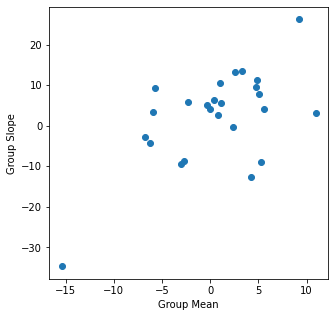

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(GROUP_MEANS, GROUP_SLOPES)
ax.set_xlabel("Group Mean")
ax.set_ylabel("Group Slope")

In [4]:
def sample_group(group_size, group_mean, group_slope, group_id):
    xs = np.random.uniform(-1, 1, size=group_size)
    ys = (
        group_mean + xs * group_slope
        + np.random.normal(loc=0.0, scale=RESIDUAL_SD, size=group_size)
    )
    return pd.DataFrame({
        'id': pd.Categorical(np.repeat(group_id, repeats=group_size)),
        'group_mean': np.repeat(group_mean, repeats=group_size),
        'group_slope': np.repeat(group_slope, repeats=group_size),
        'x': xs,
        'y': ys,
    })

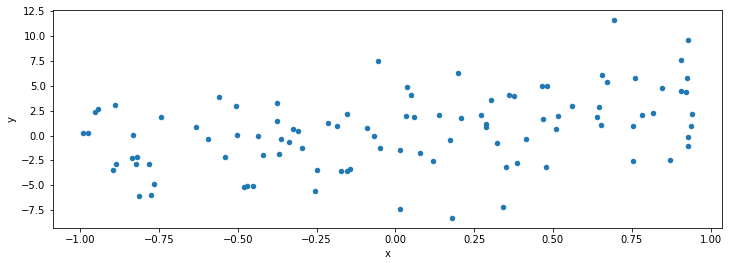

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))


sample_group(100, 0.2, 3.0, 1).loc[:, ['x', 'y']].plot.scatter('x', 'y', ax=ax)

In [6]:
def sample_data(group_sizes, group_means, group_slopes):
    assert len(group_sizes) == len(group_means)
    assert len(group_sizes) == len(group_slopes)
    dfs = []
    for id, (size, mean, slope) in enumerate(zip(group_sizes, group_means, group_slopes)):
        dfs.append(sample_group(size, mean, slope, id))
    return pd.concat(dfs).reset_index()

In [7]:
data = sample_data(GROUP_SIZES, GROUP_MEANS, GROUP_SLOPES)

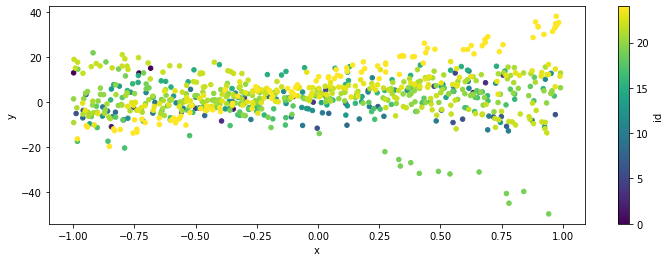

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))

data.loc[:, ['x', 'y', 'id']].plot.scatter('x', 'y', c='id', colormap='viridis', ax=ax)

In [9]:
model = smf.mixedlm("y ~ x", data, re_formula='1 + x', groups=data['id'])

In [10]:
fit_model = model.fit()

In [11]:
fe, re, recov = fit_model.fe_params, fit_model.random_effects, fit_model.random_effects_cov

model_parameters_df = pd.DataFrame([
    [fe[0] + re[id][0], fe[1] + re[id][1], recov[id].iloc[0, 0], recov[id].iloc[0, 1], recov[id].iloc[1, 1]]
    for id in range(N_GROUPS)
], columns=['alpha', 'beta', 'var_alpha', 'cov_alpha_beta', 'var_beta'])

In [12]:
model_parameters_df.head()

,alpha,beta,var_alpha,cov_alpha_beta,var_beta
0,5.358389,-9.233295,25.233131,30.375015,40.647554
1,2.601630,10.999594,2.931198,3.831035,37.002686
2,-0.124262,7.604830,3.136116,1.892638,5.954647
3,1.088666,11.069663,2.547726,0.374160,10.629860
4,0.138680,6.210701,6.926314,12.506660,35.615928


In [13]:
model_parameters_df.tail()

,alpha,beta,var_alpha,cov_alpha_beta,var_beta
20,2.178333,0.710688,0.085654,0.010979,0.264869
21,4.864783,9.201426,0.088218,0.026625,0.234776
22,4.448894,-13.789078,0.085265,-0.004035,0.246457
23,4.932812,8.776202,0.085199,-0.000402,0.299876
24,9.124824,26.104784,0.085243,-0.003427,0.265615


In [14]:
fixed_effects_cov = {
    'intercept': fit_model.cov_params().loc['Intercept', 'Intercept'],
    'slope': fit_model.cov_params().loc['x', 'x'],
    'intercept_slope': fit_model.cov_params().loc['Intercept', 'x'],
}

In [15]:
fixed_effects_cov

{'intercept': 1.4634484914870753,
 'slope': 5.667347891085994,
 'intercept_slope': 1.6496829234910786}

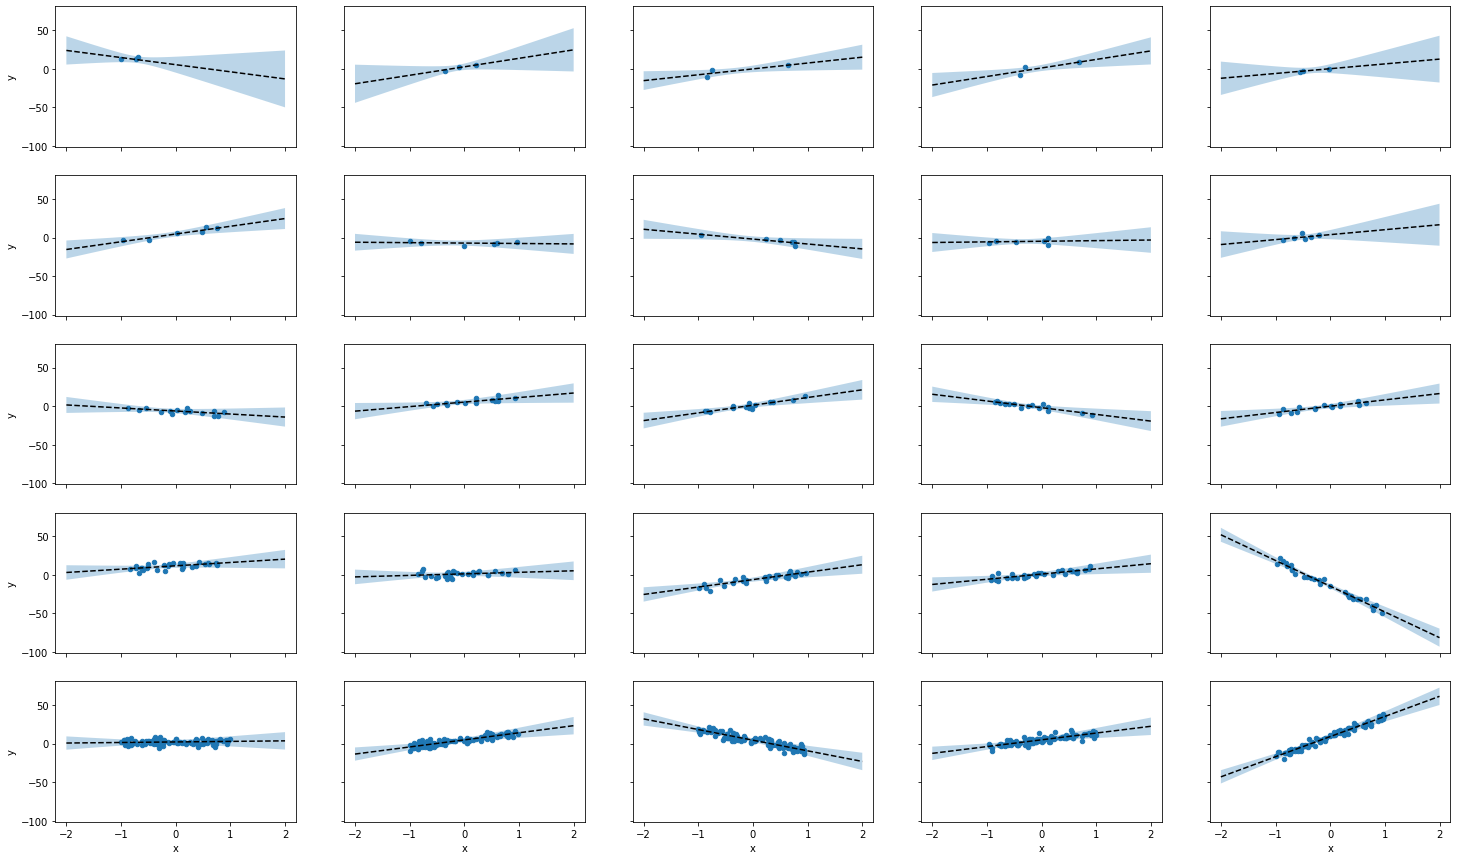

In [21]:
fig, axs = plt.subplots(N_GROUPS // 5, 5, figsize=(N_GROUPS, 15), sharey=True, sharex=True)


t = np.linspace(-2, 2, num=100)

for id, ax in zip(range(N_GROUPS), axs.flatten()):
    group_data = data.loc[data['id'] == id]
    group_data.plot.scatter('x', 'y', ax=ax)
    
    group_params = model_parameters_df.loc[id]
    regression_line = group_params['alpha'] + group_params['beta'] * t
    ax.plot(t, regression_line, color='black', linestyle='--')
    
    # This expression is derived by expanding the expression using the bi-linearity of covariance:
    #     var(alpha_fe + alpha_re + (beta_fe + beta_re) * t)
    # We're assuming that cov(fe, re) = 0, which I believe is true?
    prediction_sd = np.sqrt(
        group_params['var_alpha'] + 2 * t * group_params['cov_alpha_beta'] + group_params['var_beta'] * t**2
        + fixed_effects_cov['intercept'] + 2 * t * fixed_effects_cov['intercept_slope'] + fixed_effects_cov['slope'] * t**2
    )
    upper_band, lower_band = regression_line + 2 * prediction_sd, regression_line - 2 * prediction_sd
    ax.fill_between(t, upper_band, lower_band, alpha=0.3)